# Solving a two-asset HANK model in sequence space

In this notebook we show how to
1. [Set up a two-asset heterogenous household block with convex portfolio adjustment costs](#1-calibration)

This notebook accompanies the working paper Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

The household problem is characterized by the Bellman equation

$$
\begin{align}
V_t(e_t, b_{t-1}, a_{t-1}) = \max_{c_t, b_t, a_t} &\left\{\frac{c_t^{1-\sigma}}{1-\sigma} + \beta E_t V_{t+1}(e_{t+1}, b_t, a_t) \right\}
\\
c_t + a_t + b_t &= (1-\tau_t)w_t n_t e_t + (1 + r_t^a)a_{t-1} + (1 + r_t^b)b_{t-1} - \Psi(a_t, a_{t-1}) 
\\
a_t &\geq 0, \quad b_t \geq \underline{b},
\end{align}
$$

where the adjustment cost function is specified as

$$
\Psi(a_t, a_{t-1}) =  \frac{\chi_1}{\chi_2}\left|\frac{a_t - (1 + r_t^a) a_{t-1}}{(1 + r_{t}^a) a_{t-1} + \chi_0}\right|^{\chi_2} \left[(1 + r_t^a) a_{t-1} + \chi_0 \right],
$$

with $\chi_0, \chi_1 > 0$ and $\chi_2 > 1.$

## 0 Import packages

The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import jacobian as jac
from het_block import het
from simple_block import simple
from solved_block import solved
import two_asset as hank2
import nonlinear

<a id="1-calibration"></a>

## 1 Calibrate steady state

In [2]:
ss = hank2.hank_ss(noisy=False)

## 2 Solved blocks

We introduce the concept of solved blocks. **ELABORATE**

### 2.1 Price setting 
The Phillips curve characterizes $(\pi)$ conditional on $(Y, mc, r):$ 

$$
\log(1+\pi_t) = \kappa_p \left(mc_t - \frac{1}{\mu_p} \right) + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1})
$$

However, unlike the simple blocks we've used in the Krusell-Smith and one-asset HANK examples, this does not have an analytical solution. This is because inflation shows up with two different time displacements. We will solve it numerically (to first order) in the exact same way we solve the models.

In [3]:
@simple
def pricing(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc

T = 300
G_pricing = jac.get_G(block_list=[pricing],
                      exogenous=['mc'],  # we know that r, Y have no first-order effect
                      unknowns=['pi'],
                      targets=['nkpc'],
                      T=T, ss=ss)

In [4]:
@solved(exogenous=['mc'], unknowns=['pi'], targets=['nkpc'])
def pricing(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc

pricing.jac(ss, T, shock_list=['mc'])

{'pi': {'mc': array([[0.1       , 0.09876543, 0.09754611, ..., 0.00249848, 0.00246763,
          0.00243717],
         [0.        , 0.1       , 0.09876543, ..., 0.00252971, 0.00249848,
          0.00246763],
         [0.        , 0.        , 0.1       , ..., 0.00256133, 0.00252971,
          0.00249848],
         ...,
         [0.        , 0.        , 0.        , ..., 0.1       , 0.09876543,
          0.09754611],
         [0.        , 0.        , 0.        , ..., 0.        , 0.1       ,
          0.09876543],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1       ]])}}

In [5]:
G_pricing

{'pi': {'mc': array([[0.1       , 0.09876543, 0.09754611, ..., 0.00249848, 0.00246763,
          0.00243717],
         [0.        , 0.1       , 0.09876543, ..., 0.00252971, 0.00249848,
          0.00246763],
         [0.        , 0.        , 0.1       , ..., 0.00256133, 0.00252971,
          0.00249848],
         ...,
         [0.        , 0.        , 0.        , ..., 0.1       , 0.09876543,
          0.09754611],
         [0.        , 0.        , 0.        , ..., 0.        , 0.1       ,
          0.09876543],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1       ]])}}

### 2.2 Equity price
The no arbitrage condition characterizes $(p)$ conditional on $(d, p, r).$

$$
p_t = \frac{d_{t+1} + p_{t+1}}{1 + r_{t+1}}
$$

In [6]:
@simple
def arbitrage(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

G_arbitrage = jac.get_G(block_list=[arbitrage],
                        exogenous=['div', 'r'],
                        unknowns=['p'],
                        targets=['equity'],
                        T=T, ss=ss)

In [7]:
@solved(exogenous=['div', 'r'], unknowns=['p'], targets=['equity'])
def arbitrage(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

arbitrage.jac(ss, T, shock_list=['div', 'r'])

{'p': {'div': array([[0.        , 0.98765432, 0.97546106, ..., 0.02498478, 0.02467633,
          0.02437168],
         [0.        , 0.        , 0.98765432, ..., 0.02529709, 0.02498478,
          0.02467633],
         [0.        , 0.        , 0.        , ..., 0.0256133 , 0.02529709,
          0.02498478],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.98765432,
          0.97546106],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.98765432],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'r': array([[  0.        , -11.06172839, -10.92516385, ...,  -0.27982953,
           -0.27637485,  -0.27296281],
         [  0.        ,   0.        , -11.06172839, ...,  -0.2833274 ,
           -0.27982953,  -0.27637485],
         [  0.        ,   0.        ,   0.        , ...,  -0.28686899,
           -0.2833274 ,  -0.27982953],
         ...,
         [  0.        ,   0.       

In [8]:
G_arbitrage

{'p': {'div': array([[0.        , 0.98765432, 0.97546106, ..., 0.02498478, 0.02467633,
          0.02437168],
         [0.        , 0.        , 0.98765432, ..., 0.02529709, 0.02498478,
          0.02467633],
         [0.        , 0.        , 0.        , ..., 0.0256133 , 0.02529709,
          0.02498478],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.98765432,
          0.97546106],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.98765432],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'r': array([[  0.        , -11.06172839, -10.92516385, ...,  -0.27982953,
           -0.27637485,  -0.27296281],
         [  0.        ,   0.        , -11.06172839, ...,  -0.2833274 ,
           -0.27982953,  -0.27637485],
         [  0.        ,   0.        ,   0.        , ...,  -0.28686899,
           -0.2833274 ,  -0.27982953],
         ...,
         [  0.        ,   0.       

### 2.3 Investment with adjustment costs

Sometimes multiple equilibrium conditions can be combined in a self-contained solved block. Investment subject to capital adjustment costs is such a case. In particular, we can use the following four equations to solve for $(K, Q)$ conditional on $(Y, w, r)$.
 
 - Production:
 
 $$
 Y_t = Z_t K_{t-1}^\alpha N_t^{1-\alpha}
 $$
 
 - Labor demand:
 
 $$
 w_t = (1-\alpha)\frac{Y_t}{N_t} mc_t
 $$
 
 - Investment equation:

$$
Q_t = 1 + \frac{1}{\delta \epsilon_I}\left(\frac{K_t-K_{t-1}}{K_{t-1}}\right)
$$

- Valuation equation

$$
(1+r_{t})Q_{t} = \alpha Z_{t+1} \left(\frac{N_{t+1}}{K_t}\right)^{1-\alpha} mc_{t+1} - \left[\frac{K_{t+1}}{K_t} - (1-\delta) + \frac{1}{2\delta \epsilon_I}\left(\frac{K_{t+1} - K_t}{K_t}\right)^2\right] + \frac{K_{t+1}}{K_t}Q_{t+1}
$$

In [9]:
@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc

@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K/K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1-alpha) * mc(+1) - (K(+1)/K -
           (1-delta) + (K(+1)/K - 1)**2 / (2*delta*epsI)) + K(+1)/K*Q(+1) - (1 + r(+1))*Q
    return inv, val

G_production = jac.get_G(block_list=[labor, investment],
                         exogenous=['Y', 'w', 'r', 'Z'],
                         unknowns=['Q', 'K'],
                         targets=['inv', 'val'],
                         T=T, ss=ss)

In [10]:
production = solved(block_list=[labor, investment],
                    exogenous=['Y', 'w', 'r', 'Z'],
                    unknowns=['Q', 'K'],
                    targets=['inv', 'val'])

production.jac(ss, T, shock_list=['Y', 'w', 'r', 'Z'])

{'N': {'Y': array([[ 1.49242424e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.49064019e+00, -1.66575548e-03, ...,
          -4.13005406e-12, -4.03354754e-12, -3.95369063e-12],
         [ 0.00000000e+00, -1.68657742e-03,  1.48906545e+00, ...,
          -8.32775964e-12, -8.13316579e-12, -7.97214390e-12],
         ...,
         [ 0.00000000e+00, -1.63262026e-10, -3.25134157e-10, ...,
           1.46917263e+00, -2.27082960e-02, -2.22587130e-02],
         [ 0.00000000e+00, -1.61440189e-10, -3.21505993e-10, ...,
          -2.29921497e-02,  1.46810324e+00, -2.38394899e-02],
         [ 0.00000000e+00, -1.60222016e-10, -3.19080017e-10, ...,
          -2.28186587e-02, -2.41374835e-02,  1.46689171e+00]]),
  'w': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.81122302e-03, -1.69112231e-03, ...,
       

In [11]:
G_production

{'N': {'Y': array([[ 1.49242424e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.49064019e+00, -1.66575548e-03, ...,
          -4.13005406e-12, -4.03354754e-12, -3.95369063e-12],
         [ 0.00000000e+00, -1.68657742e-03,  1.48906545e+00, ...,
          -8.32775964e-12, -8.13316579e-12, -7.97214390e-12],
         ...,
         [ 0.00000000e+00, -1.63262026e-10, -3.25134157e-10, ...,
           1.46917263e+00, -2.27082960e-02, -2.22587130e-02],
         [ 0.00000000e+00, -1.61440189e-10, -3.21505993e-10, ...,
          -2.29921497e-02,  1.46810324e+00, -2.38394899e-02],
         [ 0.00000000e+00, -1.60222016e-10, -3.19080017e-10, ...,
          -2.28186587e-02, -2.41374835e-02,  1.46689171e+00]]),
  'w': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.81122302e-03, -1.69112231e-03, ...,
       

## 3 Simple blocks

The usual analytical equilibrium conditions.

In [12]:
@simple
def dividend(Y, w, N, K, pi, mup, kappap, delta):
    psip = mup / (mup - 1) / 2 / kappap * np.log(1 + pi) ** 2 * Y
    I = K - (1 - delta) * K(-1)
    div = Y - w * N - I - psip
    return psip, I, div


@simple
def taylor(rstar, pi, phi):
    i = rstar + phi * pi
    return i


@simple
def fiscal(r, w, N, G, Bg):
    tax = (r * Bg + G) / w / N
    return tax


@simple
def finance(i, p, pi, r, div, omega, pshare):
    rb = r - omega
    ra = pshare * (div + p) / p(-1) + (1-pshare) * (1 + r) - 1
    fisher = 1 + i(-1) - (1 + r) * (1 + pi)
    return rb, ra, fisher


@simple
def wage(pi, w, N, muw, kappaw):
    piw = (1 + pi) * w / w(-1) - 1
    psiw = muw / (1 - muw) / 2 / kappaw * np.log(1 + piw) ** 2 * N
    return piw, psiw


@simple
def union(piw, N, tax, w, U, kappaw, muw, vphi, frisch, beta):
    wnkpc = kappaw * (vphi * N**(1+1/frisch) - muw*(1-tax)*w*N*U) + beta * np.log(1 + piw(+1)) - np.log(1 + piw)
    return wnkpc


@simple
def mkt_clearing(p, A, B, Bg):
    asset_mkt = p + Bg - B - A
    return asset_mkt

## 4 All impulse responses

Let's start by specifying how the aggregate variables of the model map into the income of households.

In [13]:
def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid


household_inc = hank2.household.attach_hetinput(income)

Now we're ready to solve for the $G$ matrix of the model!

In [14]:
block_list = [household_inc, pricing, arbitrage, production, 
              dividend, taylor, fiscal, finance, wage, union, mkt_clearing]
exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']

In [15]:
G = jac.get_G(block_list, exogenous, unknowns, targets,
              T=T, ss=ss, save=True)

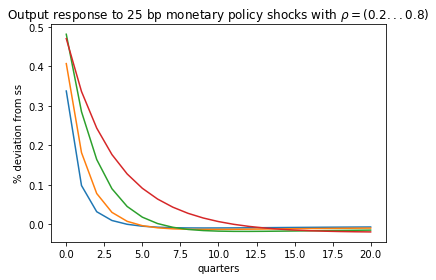

In [16]:
rhos = np.array([0.2, 0.4, 0.6, 0.8])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['Y']['rstar'] @ drstar
plt.plot(100 * dpi[:21])
plt.title(r'Output response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.8)$')
plt.xlabel('quarters'); plt.ylabel('% deviation from ss')
plt.show()

## Nonlinear impulse responses

In [17]:
%prun td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, rstar=ss['r']+drstar[:,2], use_saved=True)

On iteration 0
   max error for asset_mkt is 4.22E-06
   max error for fisher is 2.50E-03
   max error for wnkpc is 6.15E-08
On iteration 1
   max error for asset_mkt is 2.79E-04
   max error for fisher is 1.49E-06
   max error for wnkpc is 2.61E-05
On iteration 2
   max error for asset_mkt is 8.78E-06
   max error for fisher is 9.99E-08
   max error for wnkpc is 7.67E-07
On iteration 3
   max error for asset_mkt is 5.15E-07
   max error for fisher is 2.62E-09
   max error for wnkpc is 2.08E-08
On iteration 4
   max error for asset_mkt is 3.12E-08
   max error for fisher is 1.39E-10
   max error for wnkpc is 1.03E-09
On iteration 5
   max error for asset_mkt is 1.92E-09
   max error for fisher is 7.90E-12
   max error for wnkpc is 5.64E-11
 

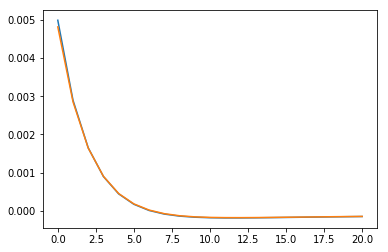

In [18]:
plt.plot(td_nonlin['Y'][:21]-1)
plt.plot(dpi[:21, 2])

## Determinacy testing...

In [25]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True)

In [26]:
import determinacy as det
det.winding_criterion(A)

0

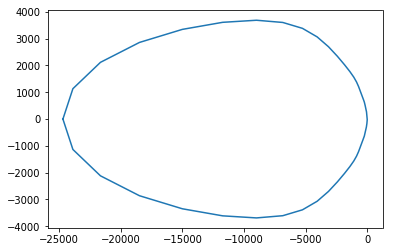

In [27]:
det_Alambda = det.detA_path(A)
plt.plot(det_Alambda.real, det_Alambda.imag)

In [28]:
ss_new = {**ss, 'phi': 0.5}

In [29]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss_new, asymptotic=True)

In [30]:
det.winding_criterion(A)

-1